In [84]:
import sqlite3 as sq3
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import elo
import config
import matplotlib.pyplot as plt
%matplotlib inline

conn = sq3.connect(config.mlb_db_path)
event = pd.read_sql(sql='select * from bevent where gameid like "%201%"', con=conn)

event['date'] = event['gameid'].apply(lambda x: int(x[3:]))
cut_point = 201707060
learn, test = event[event['date'] < cut_point], event[event['date'] >= cut_point]
print('Test/Learn Ratio: {}%'.format(round(float(len(test))/float(len(learn)),4)*100))

Test/Learn Ratio: 19.62%


In [85]:
learn['hteam'] = learn['gameid'].apply(lambda x: x[:3])
cv = learn[['gameid','eventnum']].groupby('gameid').max().reset_index()
wl = cv.merge(learn[['gameid','eventnum','hscore','vscore','hteam','vteam']], on=['gameid','eventnum'])[['hscore','vscore','hteam','vteam']]

In [86]:
wl['winner'] = np.where(wl['hscore']>wl['vscore'],wl['hteam'],wl['vteam'])
wl['loser'] = np.where(wl['hscore']<wl['vscore'],wl['hteam'],wl['vteam'])

wl_ = wl[wl['hscore'] != wl['vscore']]

In [98]:
for i in wl_.index:
    if wl_.loc[i,'winner'] == wl_.loc[i,'hteam']:
        score_dict = [{'lose_score':wl_.loc[i,'hscore'],
                      'win_score':wl_.loc[i,'vscore']}]
        wl_.loc[i,'scoreing'] = score_dict
    else:
        score_dict = [{'lose_score':wl_.loc[i,'hscore'],
                      'win_score':wl_.loc[i,'vscore']}]
        wl_.loc[i,'scoreing'] = score_dict

In [102]:
xx = wl_[['winner','loser','scoreing']]

In [103]:
players = list(set(xx['winner'].tolist()))

(array([2., 0., 2., 0., 1., 1., 2., 1., 2., 1., 3., 3., 6., 1., 4., 3.]),
 array([1043.77517354, 1099.06939202, 1154.3636105 , 1209.65782899,
        1264.95204747, 1320.24626595, 1375.54048444, 1430.83470292,
        1486.1289214 , 1541.42313988, 1596.71735837, 1652.01157685,
        1707.30579533, 1762.60001382, 1817.8942323 , 1873.18845078,
        1928.48266926]),
 <a list of 16 Patch objects>)

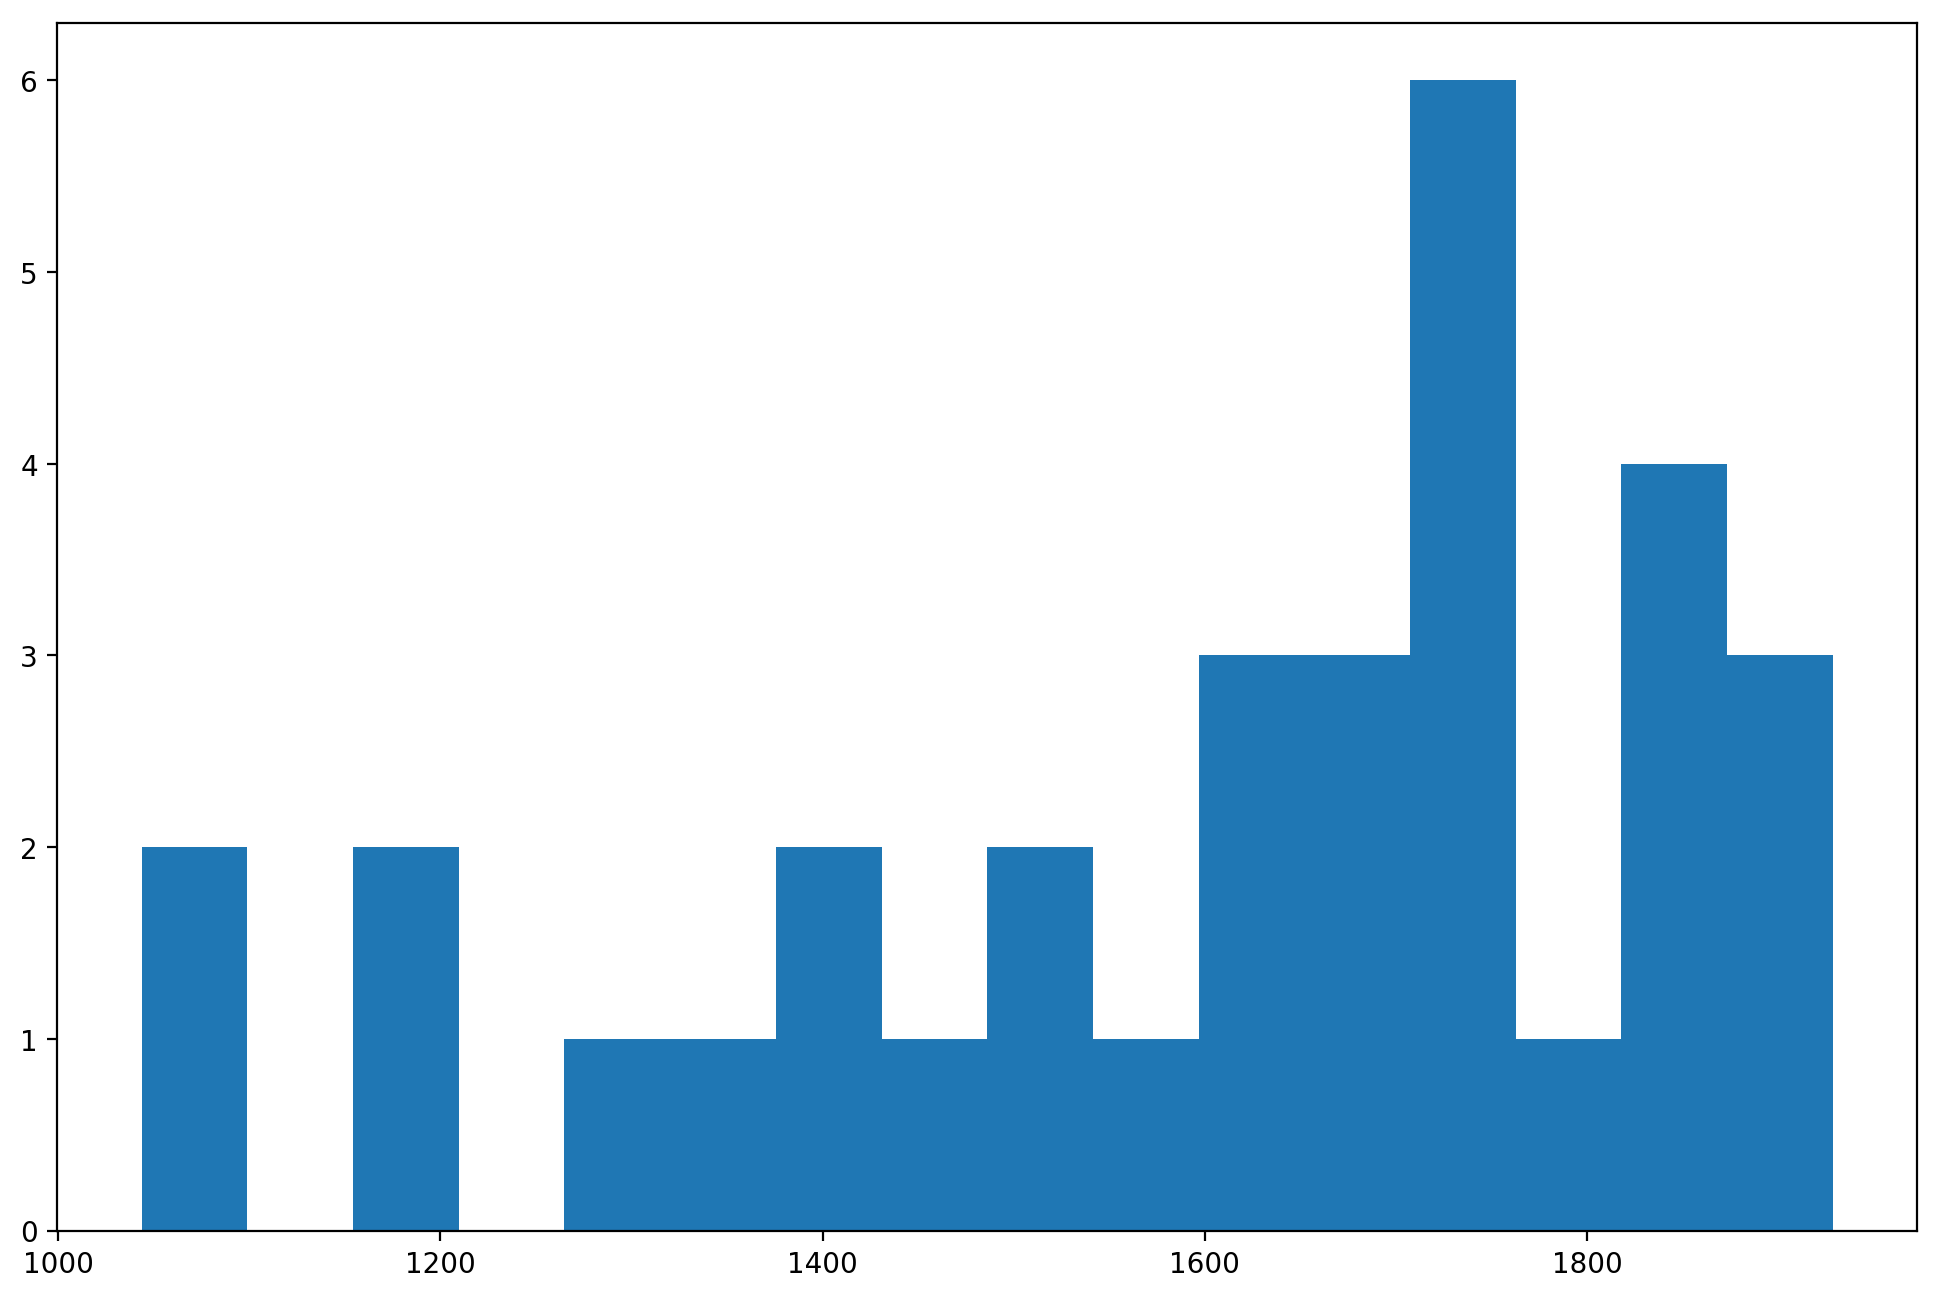

In [122]:
EL = elo.ELO(player_list=players, K=32,score_div_factor=2)
for w,l,s in zip(xx['winner'].tolist(),xx['loser'].tolist(),xx['scoreing']):
    EL.do_competition(winner=w,loser=l, scoring=s)

elo_vals = pd.DataFrame.from_dict(EL.EM.player_elo_cache, columns=['ELO'], orient='index')
EL.get_win_probibility(elo_vals['ELO'].min(),elo_vals['ELO'].max())

fig, ax1 = plt.subplots(figsize=(12,8),dpi=200)
ax1.hist(elo_vals['ELO'], bins=16)